In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from xgboost import XGBClassifier, plot_importance





In [ ]:
df = pd.read_csv('flights.csv')
df.head(10)

/tmp/ipython-input-3316898581.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('flights.csv')


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,...,610.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,...,509.0,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,...,753.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,...,532.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,...,656.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Retira cancelados, desviados e colunas que não serão usadas
cancelled_diverted_mask = (df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)
df = df[cancelled_diverted_mask].reset_index(drop=True)
drop_columns = ['CANCELLED', 'DIVERTED','CANCELLATION_REASON','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY','FLIGHT_NUMBER',
                'TAIL_NUMBER','ARRIVAL_TIME','WHEELS_ON','TAXI_IN','TAXI_OUT','WHEELS_OFF','DEPARTURE_TIME','DEPARTURE_DELAY','ELAPSED_TIME','AIR_TIME','YEAR','DESTINATION_AIRPORT','SCHEDULED_ARRIVAL']
df = df.drop(columns=drop_columns)





/tmp/ipython-input-938908404.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(


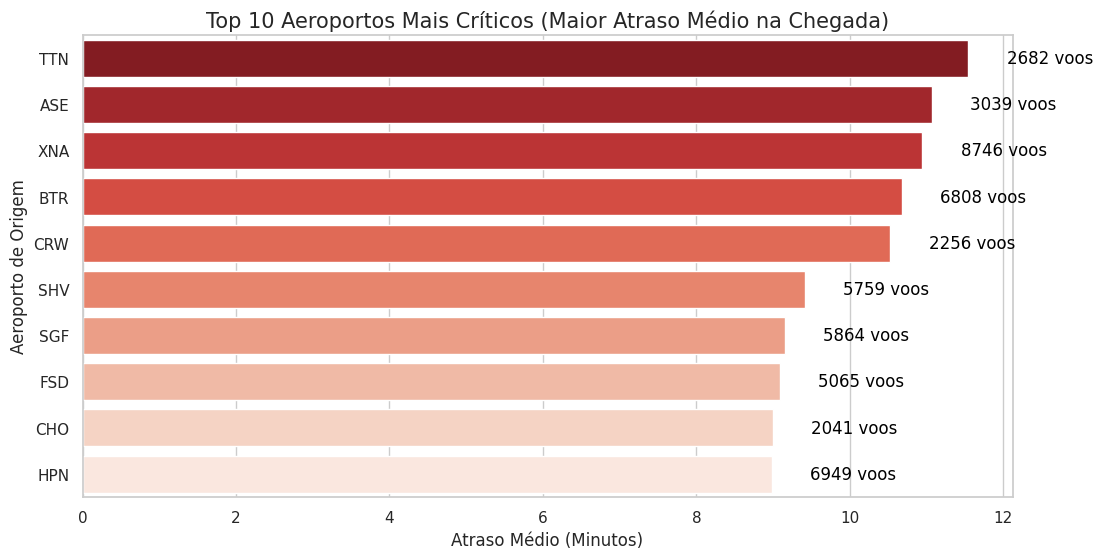

In [ ]:
#Cria gráfico de barras
stats_aeroporto = df.groupby('ORIGIN_AIRPORT')['ARRIVAL_DELAY'].agg(['mean', 'count']).reset_index()
min_voos = stats_aeroporto['count'].quantile(0.75)
aeroportos_criticos = stats_aeroporto[stats_aeroporto['count'] > min_voos]
top_10_atrasados = aeroportos_criticos.sort_values(by='mean', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
plot = sns.barplot(
    data=top_10_atrasados,
    x='mean',
    y='ORIGIN_AIRPORT',
    palette='Reds_r'
)

plt.title('Top 10 Aeroportos Mais Críticos (Maior Atraso Médio na Chegada)', fontsize=15)
plt.xlabel('Atraso Médio (Minutos)', fontsize=12)
plt.ylabel('Aeroporto de Origem', fontsize=12)
for i, row in enumerate(top_10_atrasados.itertuples()):
    plot.text(row.mean + 0.5, i, f'{int(row.count)} voos', color='black', va='center')

plt.show()



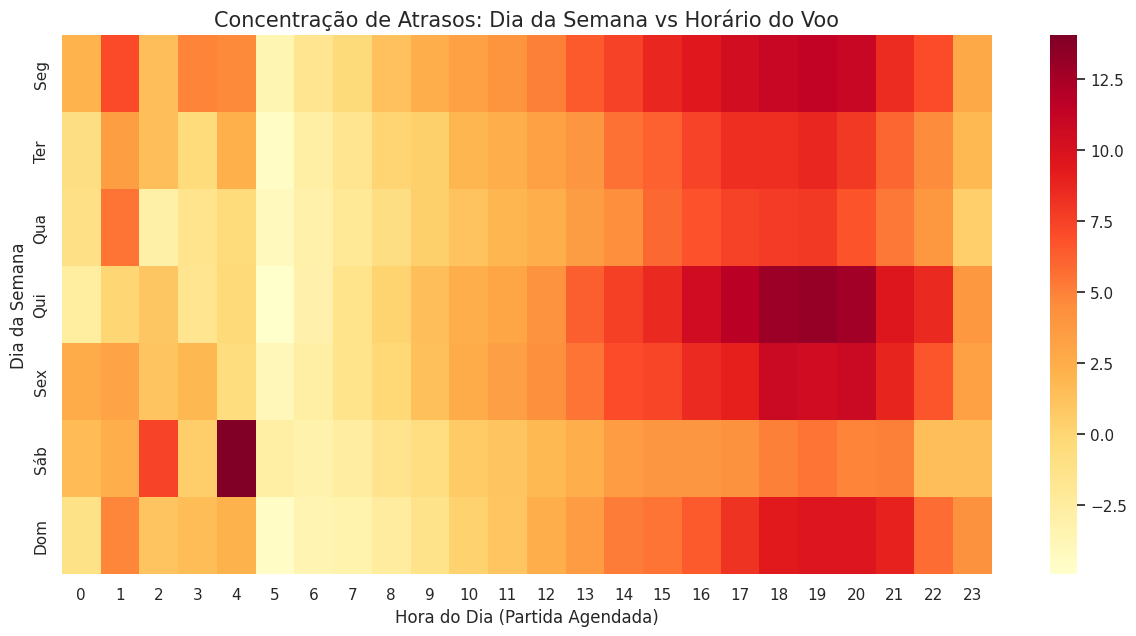

In [ ]:

#Cria mapa de calor
df['HOUR'] = df['SCHEDULED_DEPARTURE'] // 100
dias_map = {1: 'Seg', 2: 'Ter', 3: 'Qua', 4: 'Qui', 5: 'Sex', 6: 'Sáb', 7: 'Dom'}
df['DAY_NAME'] = df['DAY_OF_WEEK'].map(dias_map)
ordem_dias = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
plt.figure(figsize=(15, 7))
pivot_atrasos = df.pivot_table(
    index='DAY_NAME',
    columns='HOUR',
    values='ARRIVAL_DELAY',
    aggfunc='mean'
).reindex(ordem_dias)

sns.heatmap(pivot_atrasos, cmap='YlOrRd', annot=False)

plt.title('Concentração de Atrasos: Dia da Semana vs Horário do Voo', fontsize=15)
plt.xlabel('Hora do Dia (Partida Agendada)', fontsize=12)
plt.ylabel('Dia da Semana', fontsize=12)
plt.show()


In [ ]:
df.head(5)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,HOUR,DAY_NAME
0,1,1,4,AS,ANC,5,205.0,1448,-22.0,0,Qui
1,1,1,4,AA,LAX,10,280.0,2330,-9.0,0,Qui
2,1,1,4,US,SFO,20,286.0,2296,5.0,0,Qui
3,1,1,4,AA,LAX,20,285.0,2342,-9.0,0,Qui
4,1,1,4,AS,SEA,25,235.0,1448,-21.0,0,Qui


In [ ]:


df = df.drop(columns=['HOUR', 'DAY_NAME'])
#Encoda os dados e prepara para modelo de classificação
air_line_encoder = OneHotEncoder(sparse_output=False)
air_line_encoded = air_line_encoder.fit_transform(df[['AIRLINE']])
df = pd.concat([df, pd.DataFrame(air_line_encoded, columns=air_line_encoder.get_feature_names_out(['AIRLINE']))], axis=1)
df = df.drop(columns=['AIRLINE'])





In [ ]:
df['ORIGIN_AIRPORT'] = df['ORIGIN_AIRPORT'].astype(str)
air_port_encoder = LabelEncoder()
df['ORIGIN_AIRPORT'] = air_port_encoder.fit_transform(df['ORIGIN_AIRPORT'])

In [ ]:
df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 10 else 0)
scaler = StandardScaler()
X = df.drop(columns=['ARRIVAL_DELAY'])
y = df['ARRIVAL_DELAY']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Acurácia do Modelo XGBoost: 65.04%
              precision    recall  f1-score   support

           0       0.87      0.65      0.74    871385
           1       0.34      0.65      0.44    240192

    accuracy                           0.65   1111577
   macro avg       0.60      0.65      0.59   1111577
weighted avg       0.76      0.65      0.68   1111577



/tmp/ipython-input-4086258009.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y='Feature', data=feature_importances_xgb, palette='viridis')


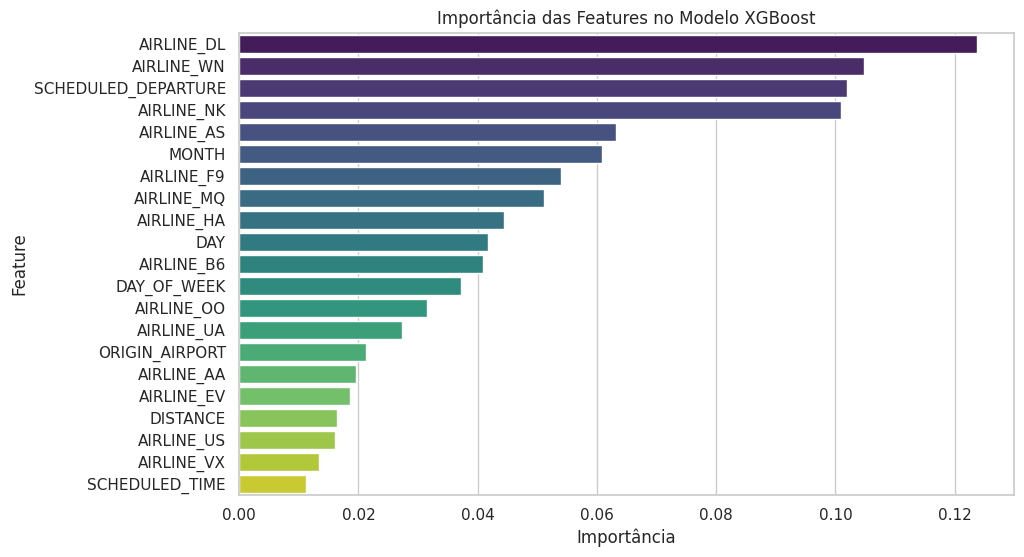

In [ ]:

#Roda modelo de classificação e plota um gráfico
xgb = XGBClassifier(
    scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]),
    eval_metric = "logloss"
)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Acurácia do Modelo XGBoost: {accuracy_xgb * 100:.2f}%')
print(classification_report(y_test, y_pred_xgb))
xgb_importance = xgb.feature_importances_
feature_importances_xgb = pd.DataFrame({'Feature': X.columns, 'Importância': xgb_importance})
feature_importances_xgb = feature_importances_xgb.sort_values(by='Importância', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Feature', data=feature_importances_xgb, palette='viridis')
plt.title('Importância das Features no Modelo XGBoost')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()
